In [1]:
from gurobipy import *
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shapefile as shp
from collections import defaultdict

### Set Parameters

In [2]:
M = 100000
maxOpenD = 6
maxOpenA = 3
maxDistance = 10000

maxDist_D = 150
maxDist_A = 350

#maxPopD- max capacity of each district court
#maxPopA - max capacity of each appeals court

#xS,yS 
#xD,yD
#xA,yA

#langS
#langD
#langA


#param d{i in Settlements,j in DistrictCourts} 
#	:= sqrt( (xS[i]-xD[j])^2 + (yS[i]-yD[j])^2); #distance between settlement and district court
#param a{i in Settlements,k in AppealsCourts} 
#	:= sqrt( (xA[k]-xS[i])^2 + (yA[k]-yS[i])^2); #distance between district court and appeals court	

### Extract Data

In [3]:
#Get Settlement List
#Settlements = pd.read_csv("afg_ppl_settlement_pnt.csv",sep=",")
#Settlements=pd.read_csv("prov_code_3.csv",sep=",")
Settlements = pd.read_csv("settlements24_26.csv",sep=",")

Settlements = Settlements[["OBJECTID","LAT_Y","LON_X"]]
#Settlements=Settlements[[0,10,11]]
S = Settlements.shape[0]
Settlement_List = Settlements['OBJECTID'].tolist()

#Get District Court List
Districts = pd.read_csv("District_Courts.csv",sep=",")
Districts = Districts[[1,4,5]]
D = Districts.shape[0]
District_List = Districts['DIST_CODE'].tolist()

#Get Appeals Court List
Appeals = pd.read_csv("Appeals_Courts.csv",sep=",")
Appeals = Appeals[[1,4,5]]
A = Appeals.shape[0]
Appeals_List = Appeals['PROV_CODE'].tolist()

#### Create Data Subset for Settlements

#### ------------------------------------------------

In [4]:
#Settlements = Settlements.sample(frac = 0.02, replace = False, random_state = 23)
S = Settlements.shape[0]
Settlement_List = Settlements['OBJECTID'].tolist()

####  ------------------------------------------------

In [5]:
#Create Dictionaries
Settlement_Dict = Settlements.set_index('OBJECTID').T.to_dict('list')
District_Dict = Districts.set_index('DIST_CODE').T.to_dict('list')
Appeals_Dict = Appeals.set_index('PROV_CODE').T.to_dict('list')

In [6]:
#Create Dictionaries for District Courthouse Distances

Dist_D = {}

R = 6371e3


for d in District_List:
    d_lon = District_Dict[d][0]
    d_lat = District_Dict[d][1]
    phi2 = np.radians(d_lat)


    for s in Settlement_List:
        s_lon = Settlement_Dict[s][1]
        s_lat = Settlement_Dict[s][0]
        phi1 = np.radians(s_lat)
        
        #Distance to District Court
        delta_phi = np.radians(d_lat - s_lat)
        delta_lambda = np.radians(d_lon - s_lon)
        a = np.sin(delta_phi/2) * np.sin(delta_phi/2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2) * np.sin(delta_lambda/2)
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        
        Dist_D[s,d] = (R * c)/1000
    

In [7]:
#Create Dictionaries for Appeals Courthouse Distances

Dist_A = {}

R = 6371e3

for a in Appeals_List:
    a_lon = Appeals_Dict[a][0]
    a_lat = Appeals_Dict[a][1]
    theta_3 = np.radians(a_lat)

    for s in Settlement_List:
        s_lon = Settlement_Dict[s][1]
        s_lat = Settlement_Dict[s][0]
        theta_1 = np.radians(s_lat)
        
        #Distance to District Court
        delta_theta_ = np.radians(a_lat - s_lat)
        delta_lambda = np.radians(a_lon - s_lon)
        a1 = np.sin(delta_theta_/2) * np.sin(delta_theta_/2) + np.cos(theta_1) * np.cos(theta_3) * np.sin(delta_lambda/2) * np.sin(delta_lambda/2)
        c = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))
        
        Dist_A[s,a] = (R * c)/1000
        
    

### Create Model

In [8]:
#Create Model
m = Model("Afghanistan")

#Suppress output
m.Params.OutputFlag = 1
m.Params.LogFile="log_prov_24_26_with3appeals.log"
m.params.LazyConstraints = 1

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to log_prov_24_26_with3appeals.log
   Prev: gurobi.log  Default: 
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0


### Create Variables

##### Helper function

In [9]:
# Return value of variable
def VarVal(var):
    if (type(var) == gurobipy.Var):
        val = var.X

    else:
        val = 0
    return val

##### d_ij

In [10]:
# Create d_i_j variables
d = {}
for i in Settlement_List:
    d[i] = {}
    for j in District_List:
        if Dist_D[i,j] < maxDist_D:
            d[i][j] = m.addVar(vtype=GRB.BINARY, name='d_%s_%s' % (i, j))
            d[i][j].start=10000
        else:
            d[i][j] = 0
m.update()

In [11]:
# Create d_i_j transpose dictionary 
d_t = defaultdict(dict)
for key, val in d.items():
    for subkey, subval in val.items():
        d_t[subkey][key] = subval

##### a_ik

In [12]:
 # Create a_i_k variables
a = {}
for i in Settlement_List:
    a[i] = {}
    for k in Appeals_List:
        if Dist_A[i,k] < maxDist_A:
            a[i][k] = m.addVar(vtype=GRB.BINARY, name='a_%s_%s' % (i, k))
            a[i][k].start=0
        else:
            a[i][k] = 0
m.update()

In [13]:
# Create a_i_k transpose dictionary 
a_t = defaultdict(dict)
for key, val in a.items():
    for subkey, subval in val.items():
        a_t[subkey][key] = subval

##### c_jk

In [14]:
# Create c_j_k variables
c = {}
for j in District_List:
    c[j] = {}
    for k in Appeals_List:
        c[j][k] = m.addVar(vtype=GRB.BINARY, name='c_%s_%s' % (j, k))
        c[j][k].start=0
m.update()

In [15]:
# Create c_j_k transpose dictionary 
c_t = defaultdict(dict)
for key, val in c.items():
    for subkey, subval in val.items():
        c_t[subkey][key] = subval

##### openD

In [16]:
#Create openD variables
openD = {}
for j in District_List:
    openD[j] = m.addVar(vtype=GRB.BINARY, name='openD_%s' % (j))
    openD[j].start = 0
m.update()

##### openA

In [17]:
#Create openA variables
openA = {}
for k in Appeals_List:
    openA[k] = m.addVar(vtype=GRB.BINARY, name='openA_%s' % (k))
    openA[k].start=0
m.update()

### Create Constraints

##### D_ij row sums and column sums

In [18]:
#One S -> D Assignment
for i in Settlement_List:
    m.addConstr(quicksum(d[i][j] for j in d[i]) == 1)
m.update()

In [19]:
#Maximum District Courts Open
for j in District_List:
    m.addConstr(quicksum(d_t[j][i] for i in d_t[j]) <= M * openD[j])
m.update()

##### A_ik row sums and column sums

In [20]:
#One S -> A Assignment
for i in Settlement_List:
    m.addConstr(quicksum(a[i][k] for k in a[i]) == 1)
m.update()

In [21]:
#Maximum Appeals Courts Open
for k in Appeals_List:
    m.addConstr(quicksum(a_t[k][i] for i in a_t[k]) <= M * openA[k])
m.update()

#### C_jk row sums and column sums

In [22]:
#One D -> A Assignment
for j in District_List:
    m.addConstr(quicksum(c[j][k] for k in c[j]) == openD[j])
m.update()

In [23]:
#C constraints
for k in Appeals_List:
    m.addConstr(quicksum(c[j][k] for j in District_List) <= M*openA[k])
m.update()

##### Max Open Courthouse Constraints

In [24]:
m.addConstr(quicksum(openD[j] for j in District_List) <= maxOpenD)

m.update()

In [25]:
m.addConstr(quicksum(openA[k] for k in Appeals_List) <= maxOpenA)

m.update()

In [26]:
m

<gurobi.Model MIP instance Afghanistan: 5028 constrs, 165068 vars, Parameter changes: LogFile=log_prov_24_26_with3appeals.log, LazyConstraints=1>

### Set Objective Function

#### D_ij and A_ik

In [27]:
m.setObjective(
        quicksum(   quicksum(   Dist_D[i,j]*d_t[j][i] for i in d_t[j])    for j in District_List) + \
        quicksum(   quicksum(   Dist_A[i,k]*a_t[k][i] for i in a_t[k])    for k in Appeals_List), GRB.MINIMIZE)
m.update()

### Callback Function

In [28]:
def mycallback(model, where):        
    if where == GRB.Callback.MIPSOL:
        d_temp = {}
        a_temp = {}
        c_temp = {}
        for i in Settlement_List:
            d_temp[i] = {}
            a_temp[i] = {}
        for j in District_List:
            c_temp[j] = {}
        
        for i in Settlement_List:
            for j in District_List:
                if (type(d[i][j]) == gurobipy.Var):
                    d_temp[i][j] = m.cbGetSolution(d[i][j])
                else:
                    d_temp[i][j] = 0
        
        for i in Settlement_List:
            for k in Appeals_List:
                if (type(a[i][k]) == gurobipy.Var):
                    a_temp[i][k] = m.cbGetSolution(a[i][k])
                else:
                    a_temp[i][k] = 0
                
        for j in District_List:
            for k in Appeals_List:
                if (type(c[j][k]) == gurobipy.Var):
                    c_temp[j][k] = m.cbGetSolution(c[j][k])
                else:
                    c_temp[j][k] = 0
                
        for i in Settlement_List:
            for j in District_List:
                for k in Appeals_List:
                    if (d_temp[i][j] + a_temp[i][k] - c_temp[j][k] > 1):
                        m.cbLazy(d[i][j] + a[i][k] - c[j][k] <= 1)
                    if (d_temp[i][j] + c_temp[j][k] - a_temp[i][k] > 1):
                        m.cbLazy(d[i][j] + c[j][k] - a[i][k] <= 1)             
                    


### Optimize

In [29]:
start_time = time.time()

m.optimize(mycallback)

end_time = time.time()

print(end_time-start_time)

Optimize a model with 5028 rows, 165068 columns and 330570 nonzeros
Variable types: 0 continuous, 165068 integer (165068 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e-01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 237 rows and 0 columns
Presolve time: 0.49s
Presolved: 4791 rows, 165068 columns, 330333 nonzeros

MIP start did not produce a new incumbent solution
MIP start violates constraint R0 by 359999.000000000

Variable types: 0 continuous, 165068 integer (165068 binary)
Found heuristic solution: objective 572668.37634

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.158000e+03   0.000000e+00     87s
    4234    9.8496084e+04   0.000000e+00   0.000000e+00     87s

Root relaxation: objective 9.849608e+04, 4234 iterations, 0.05 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj 

### Output Solution

In [30]:
m.write("out.sol")

In [31]:
GRB.Attr

###  Plotting

#### DOUT

In [32]:
# DOUT - District Assignments

DOUT = pd.DataFrame.from_dict({(i,j): VarVal(d[i][j]) 
                           for i in d.keys() 
                           for j in d[i].keys()},
                           orient='index')

Settlements_DOUT = [i[0] for i in DOUT.index]
Districts_DOUT = [i[1] for i in DOUT.index]

DOUT['Settlement'] = Settlements_DOUT
DOUT['DistrictCourts'] = Districts_DOUT

DOUT = DOUT[DOUT[0] == 1.0]

#### AOUT

In [33]:
#AOUT - Appeals Assignments

AOUT = pd.DataFrame.from_dict({(i,j): VarVal(a[i][j]) 
                           for i in a.keys() 
                           for j in a[i].keys()},
                           orient='index')

Settlements_AOUT = [i[0] for i in AOUT.index]
Appeals_AOUT = [i[1] for i in AOUT.index]

AOUT['Settlement'] = Settlements_AOUT
AOUT['AppealsCourts'] = Appeals_AOUT

AOUT = AOUT[AOUT[0] == 1.0]

#### COUT

In [34]:
#COUT - Appeals Assignments

COUT = pd.DataFrame.from_dict({(i,j): VarVal(c[i][j]) 
                           for i in c.keys() 
                           for j in c[i].keys()},
                           orient='index')

Districts_COUT = [i[0] for i in COUT.index]
Appeals_COUT = [i[1] for i in COUT.index]

COUT['DistrictCourts'] = Districts_COUT
COUT['AppealsCourts'] = Appeals_COUT

COUT = COUT[COUT[0] == 1.0]

#### Plot all Locations

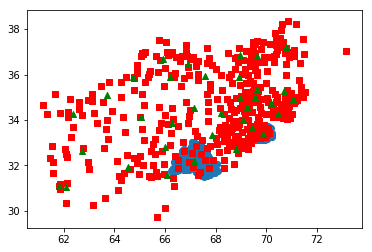

In [35]:
plt.scatter(Settlements['LON_X'],Settlements['LAT_Y'])
plt.scatter(Districts['LON_X'],Districts['LAT_Y'], color='Red', marker = 's')
plt.scatter(Appeals['LON_X'],Appeals['LAT_Y'], color='Green', marker = '^')
plt.show()

#### Plotting Assignments

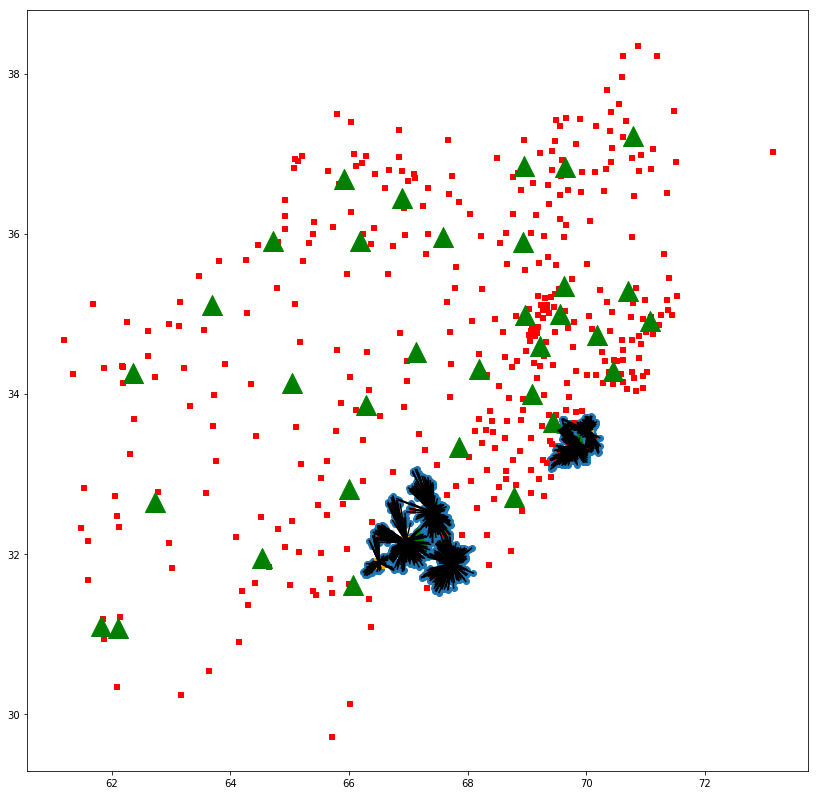

In [36]:
#Drawing Lines
plt.figure(figsize=(14,14))

#Plotting Points    
plt.scatter(Settlements['LON_X'],Settlements['LAT_Y'])
plt.scatter(Districts['LON_X'],Districts['LAT_Y'], color='Red', marker = 's',s=25)
plt.scatter(Appeals['LON_X'],Appeals['LAT_Y'], color='Green', marker = '^',s = 400)

for index,row in DOUT.iterrows():
    s = row['Settlement'] 
    d = row['DistrictCourts']
    #Get District number that Settlement is linked to
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    Sett = Settlements.loc[Settlements['OBJECTID'] == s]
    X = [Sett.iloc[0,2],Dist.iloc[0,1]]
    Y = [Sett.iloc[0,1],Dist.iloc[0,2]]
    plt.scatter(Dist.iloc[0,1],Dist.iloc[0,2], color='Orange', marker = 's',s = 100)
    plt.plot(X,Y,zorder=1, color="Black")



#axes = plt.gca()
#axes.set_xlim([68.2,70])
#axes.set_ylim([34,35.5])

plt.show()

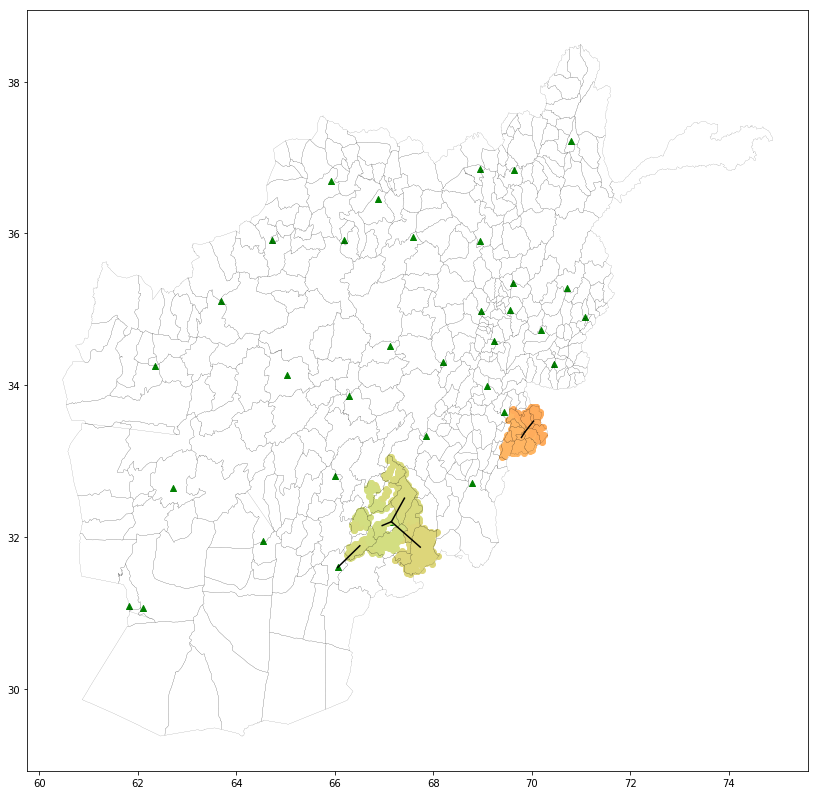

In [37]:
#Draw Lines
plt.figure(figsize=(14,14))

for index,row in COUT.iterrows():
    d = row['DistrictCourts'] 
    a = row['AppealsCourts']

    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    App = Appeals.loc[Appeals['PROV_CODE'] == a]

    X = [Dist.iloc[0,1],App.iloc[0,1]]
    Y = [Dist.iloc[0,2],App.iloc[0,2]]

    plt.plot(X,Y,zorder=1, color="Black")
    
clr = cm.rainbow(np.linspace(0, 1, D))
for a in range(A):
    X = Appeals.iloc[a,1]
    Y = Appeals.iloc[a,2]
    plt.scatter(X,Y, color="Green", marker = '^')
    
for index,row in DOUT.iterrows():   
    d = row['DistrictCourts'] 
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    X = Dist.iloc[0,1]
    Y = Dist.iloc[0,2]
    c = Dist.index[0]
    plt.scatter(X,Y, color=clr[c], marker = 's')
    
for index,row in DOUT.iterrows():
    s = row['Settlement'] 
    d = row['DistrictCourts']
    #Get District number that Settlement is linked to
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    Sett = Settlements.loc[Settlements['OBJECTID'] == s]

    c = Dist.index[0]
    X = Sett.iloc[0,2]                                                     
    Y = Sett.iloc[0,1]
    plt.scatter(X,Y, color=clr[c])
          
#axes = plt.gca()
#axes.set_xlim([68.2,70])
#axes.set_ylim([34,35.5])

sf = shp.Reader("Afghanistan_Districts","rb")
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color='k',linewidth=0.1)
plt.show()